Anthony Nazarov

## Assignment for Module 6

In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [5]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [6]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [7]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [8]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [11]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [12]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [15]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 70142.55721218  67456.39127204  67318.3258893   70866.26065275]
Mean: 68945.8837566


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with FBR kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000. 

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma. 

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [20]:
from sklearn.svm import SVR

C_vals = np.logspace(1, 5, 5) ## YOUR VALUES FOR C ##
gamma_vals = np.logspace(-3, 3, 6) ## YOUR VALUES FOR gamma ## 

param_grid = dict(C=C_vals, gamma=gamma_vals)
grid_search_rbf = GridSearchCV(SVR(kernel='rbf',cache_size=8000), param_grid, cv=3,scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_tr, np.ravel(y_tr))

GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=8000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e+01,   1.00000e+02,   1.00000e+03,   1.00000e+04,
         1.00000e+05]), 'gamma': array([  1.00000e-03,   1.58489e-02,   2.51189e-01,   3.98107e+00,
         6.30957e+01,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [21]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 100000.0, 'gamma': 0.25118864315095796}
56384.0213258


### Performance on Test Set

In [22]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

54972.8571113


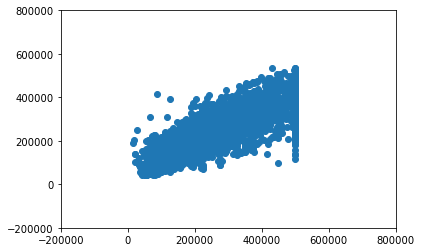

In [23]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, indicating whether or not the price is above the average $179700


In [16]:
from sklearn.metrics import accuracy_score

In [17]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [18]:
y_tr_b = 1*np.ravel(y_tr>=179700.0)
y_te_b = 1*np.ravel(y_te>=179700.0)

#### Linear SVM for classification

In [19]:
from sklearn.svm import LinearSVC

In [20]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_tr, y_tr_b)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [21]:
y_pred = lin_clf.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

0.83845514950166111

### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVM?

In [22]:
from sklearn.svm import SVC

In [23]:
svc_clf = SVC()
svc_clf.fit(X_tr, y_tr_b)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
y_pred = svc_clf.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

0.86614064230343302

Yes,  it does.

### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [27]:
params = {"C": np.logspace(-3, 2, 6),
"gamma": np.logspace(-3, 2, 6)} 

In [28]:
random_search = RandomizedSearchCV(SVC(kernel='rbf',cache_size=8000), param_distributions=params,
                                   n_iter=6)
random_search.fit(X_tr, y_tr_b)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=8000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=6, n_jobs=1,
          param_distributions={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02]), 'gamma': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [30]:
print(random_search.best_params_)

y_pred = random_search.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

{'gamma': 0.10000000000000001, 'C': 100.0}


0.90704595791805098